In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf


print(tf.__version__)

print("GPU 여부:", len(tf.config.list_physical_devices('GPU')) > 0)

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'CPU:0'
    
print(device_name)

2.9.2
GPU 여부: True
/device:GPU:0


# 합성곱 GAN, 바서슈타인 GAN
## DCGAN 생성
1. 랜덤 벡터 z를 완전 연결층으로 새로운 벡터로 투영
2. 합성곱에 사용되는 형태로 크기 변형(h x w x c)
3. 전치합성곱층을 사용해 특성 맵을 원하는 출력 크기까지 업샘플링

* 전치 합성곱
* 배치 정규화
* WGAN(바서슈타인 GAN)
* 그레이디언트 패널티

## 전치 합성곱
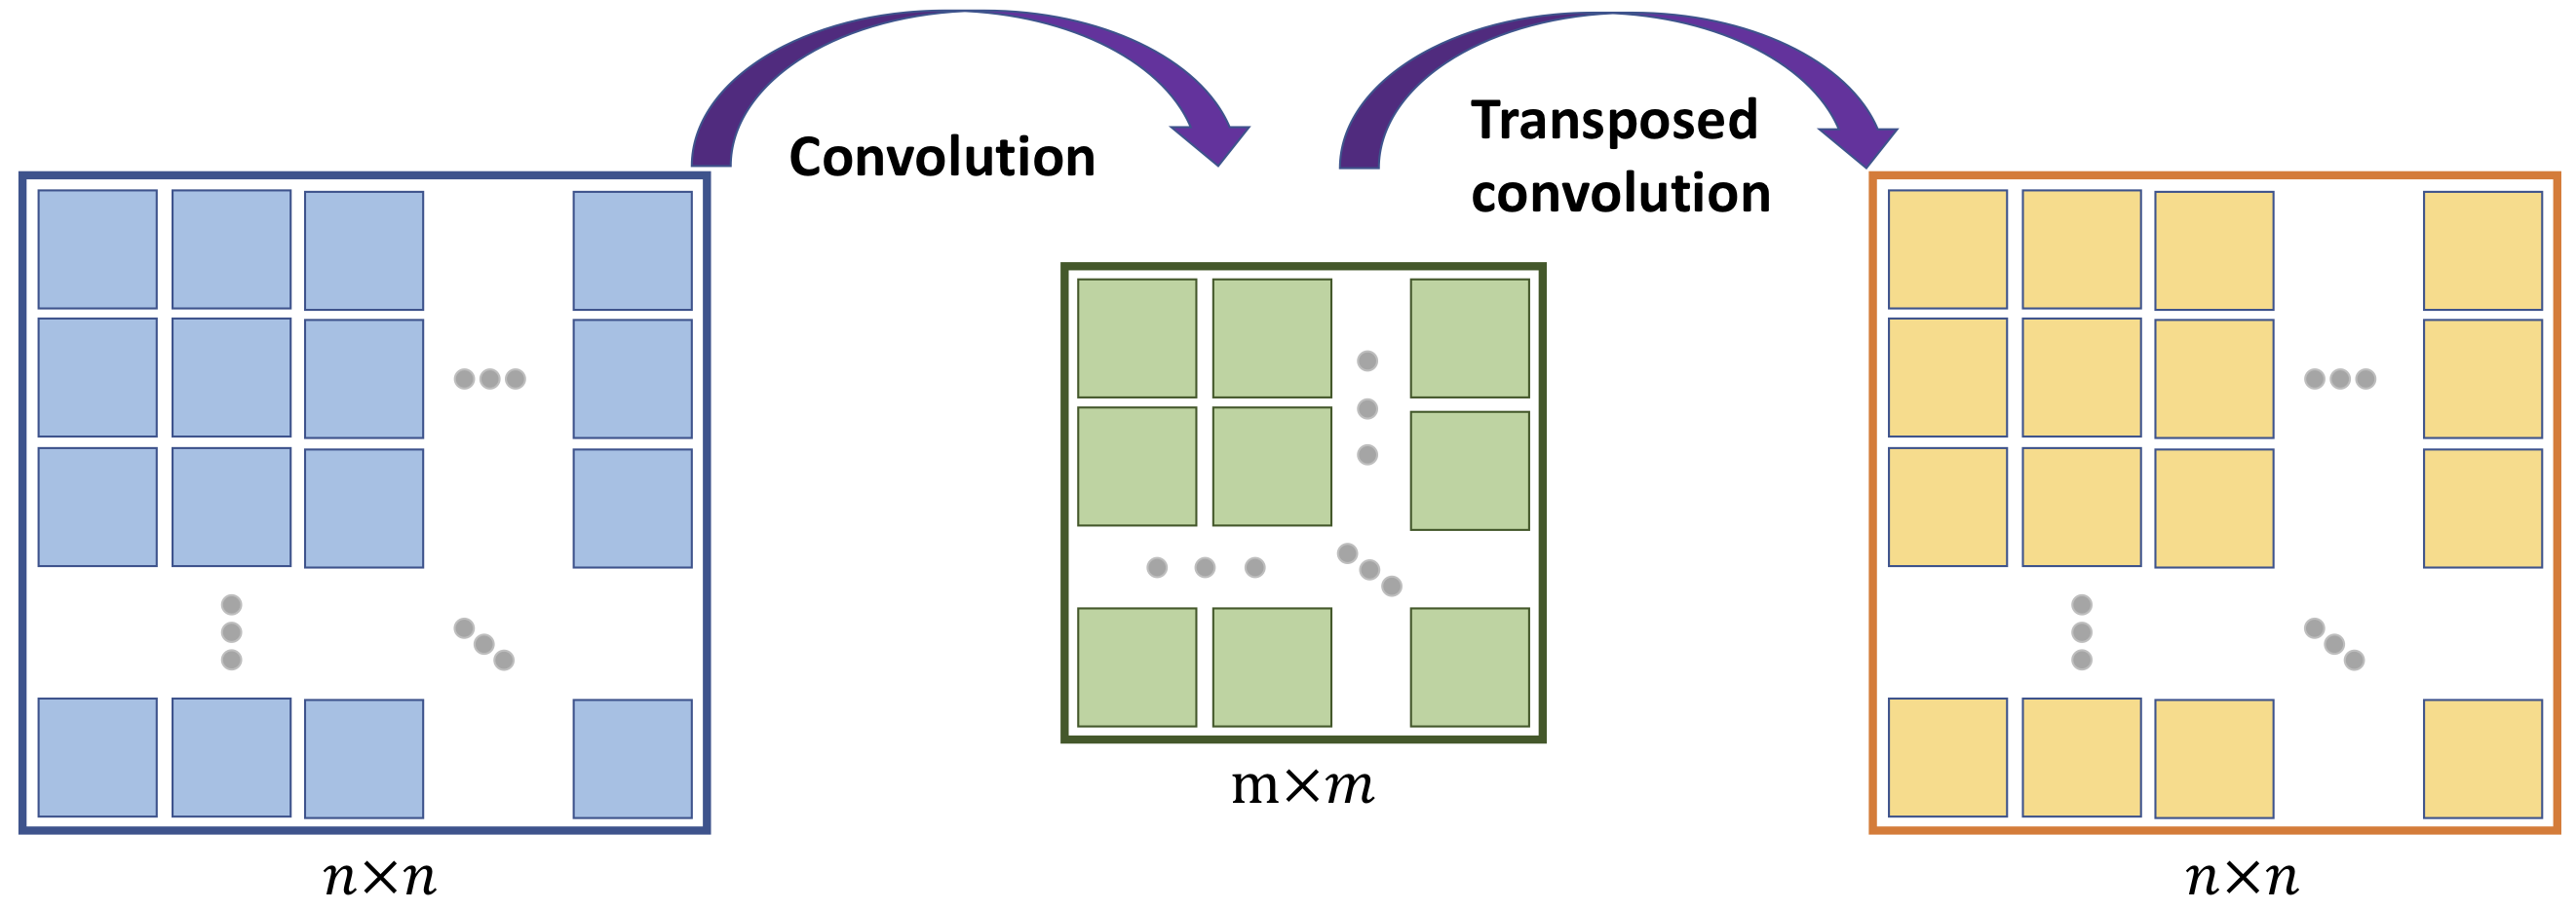

**전치 합성곱**: 입력 특성 맵 원소 사이에 0을 끼워 넣어 합성곱 수행하여 특성 맵을 업샘플링
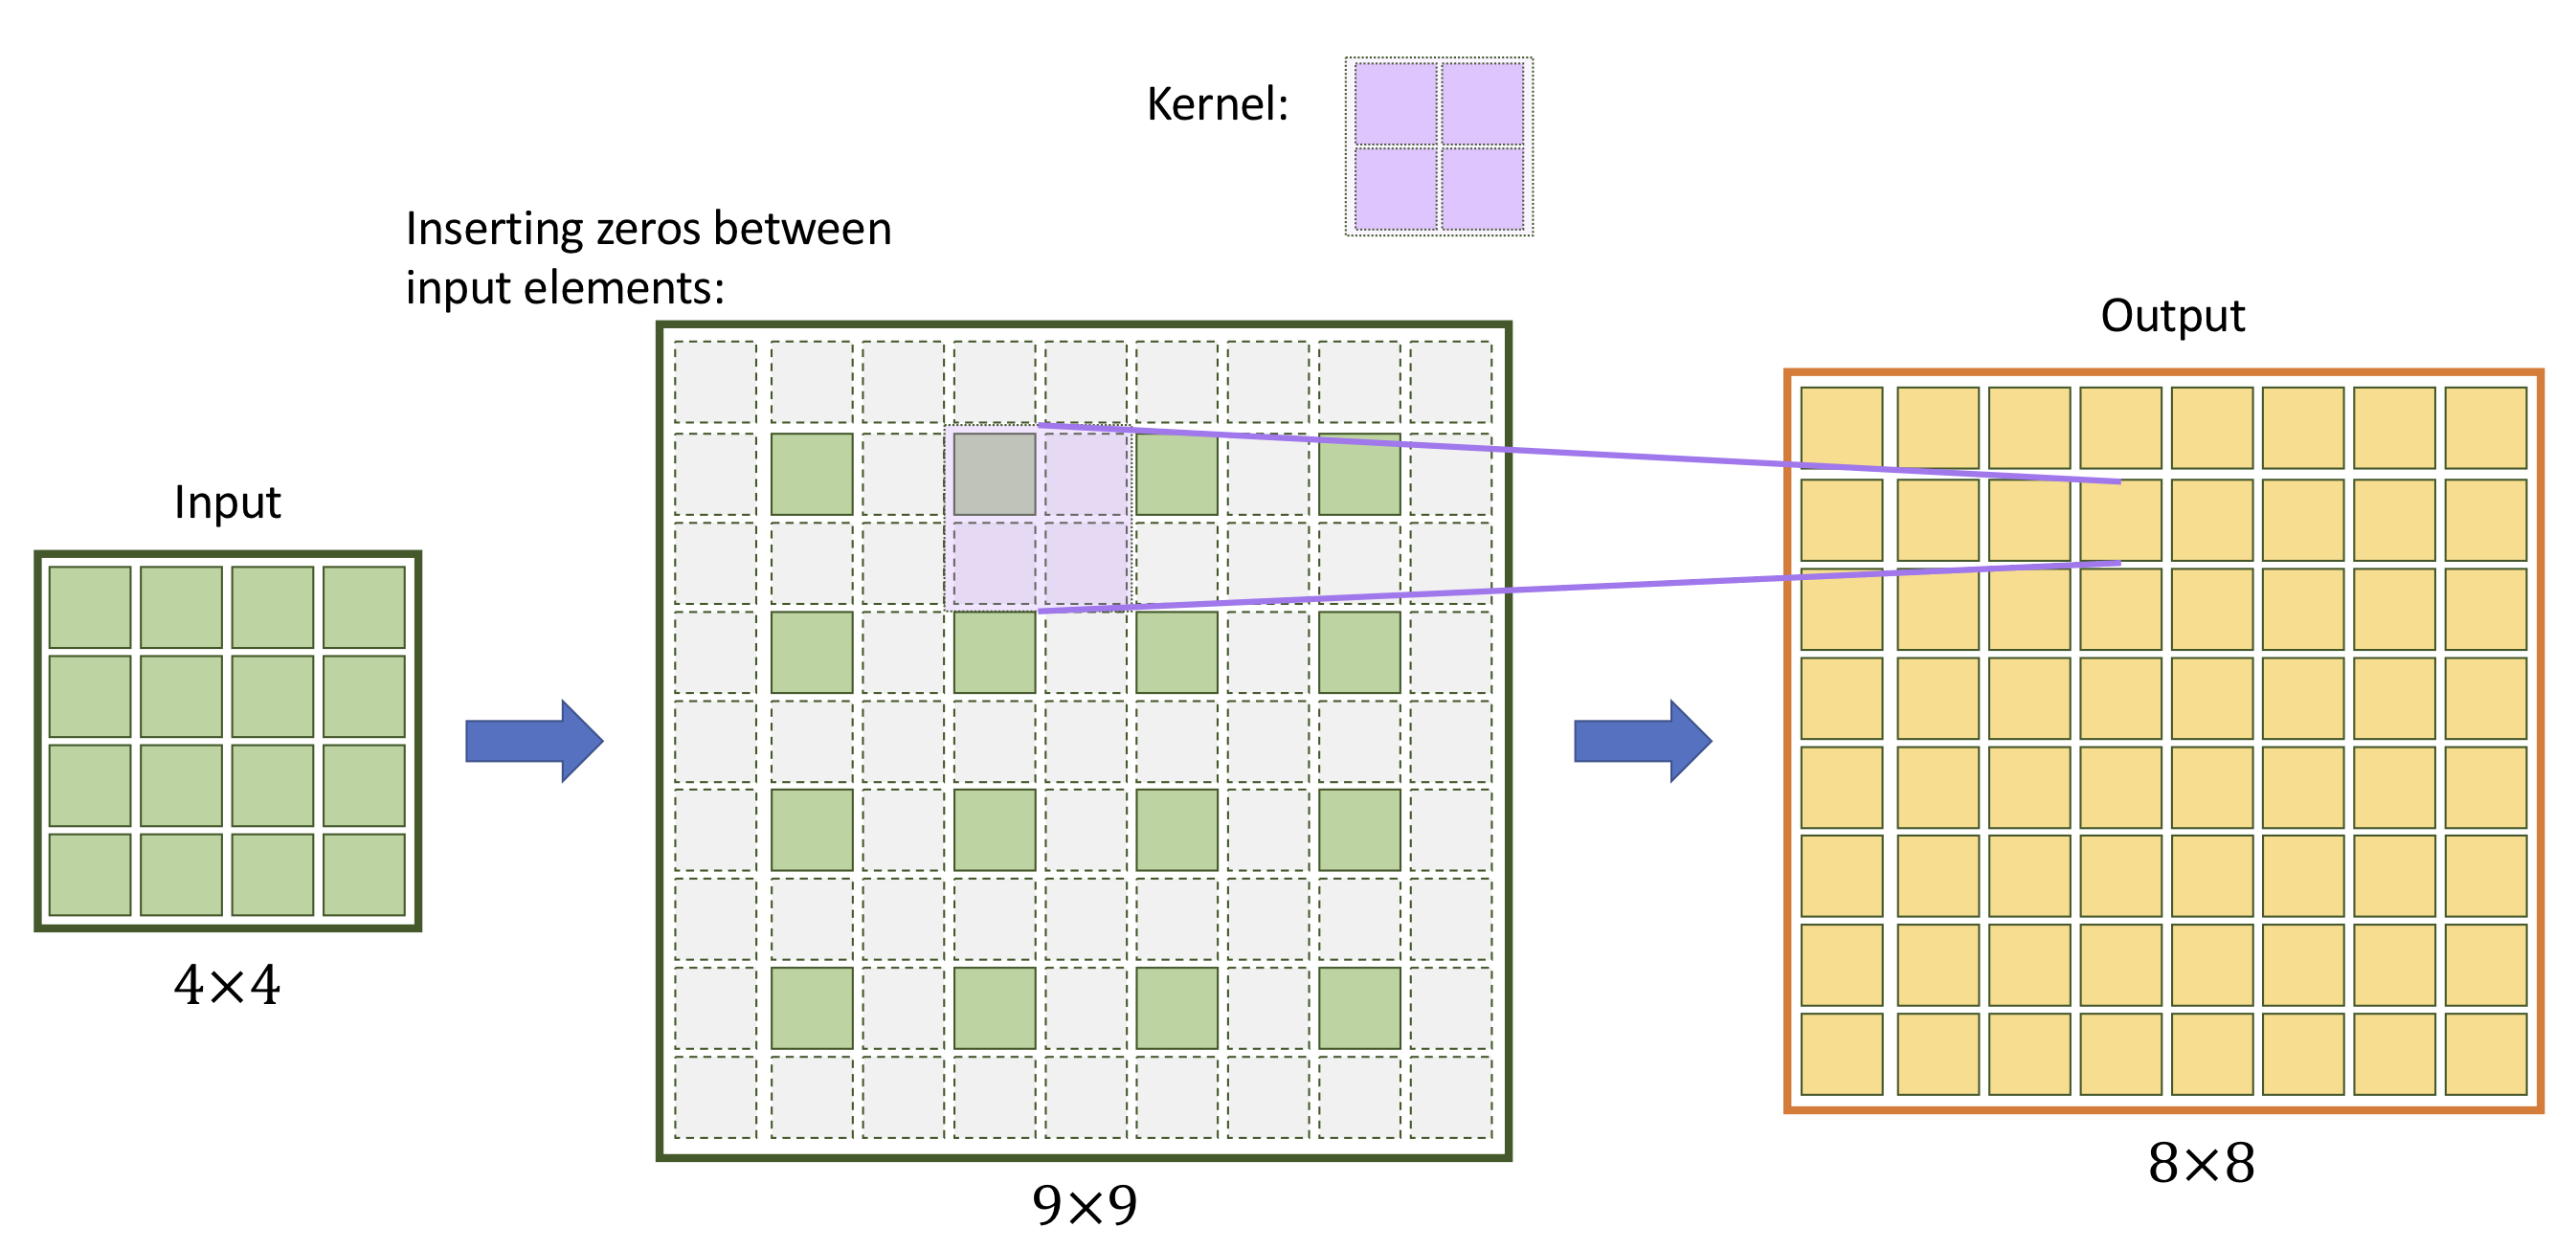

## 배치 정규화
층의 입력을 정규화 + 훈련하는 동안 입력 분포의 변화 방지
=> 모델을 빠르고 안정적으로 수렴

### 특성 맵 : [m x h x w x c] 크기의 텐서 Z
1. 미니 배치 입력의 평균과 표준 편차를 계산
$$ \mu_B = \cfrac{1}{m \times h \times w} \sum_{i, j, k} \mathbf Z^{i, j, k,.} $$
$$ \sigma^2_B = \cfrac{1}{m \times h \times w} \sum_{i, j, k} (\mathbf Z^{i, j, k,.} -\mu_B)^2$$

2. 배치에 있는 모든 샘플의 입력을 표준화
$$ \mathbf Z^i_{std} = \cfrac{\mathbf Z^i - \mu_B}{\sigma_B + \epsilon} $$

3. 정규화된 입력을 학습되는 두 개의 파라미터 벡터 $\gamma $와 $\beta$로 스케일을 조정하고 이동시킴
$$ \mathbf A^i_{pre} = \mathbf \gamma \mathbf Z^i_{std} + \mathbf \beta $$

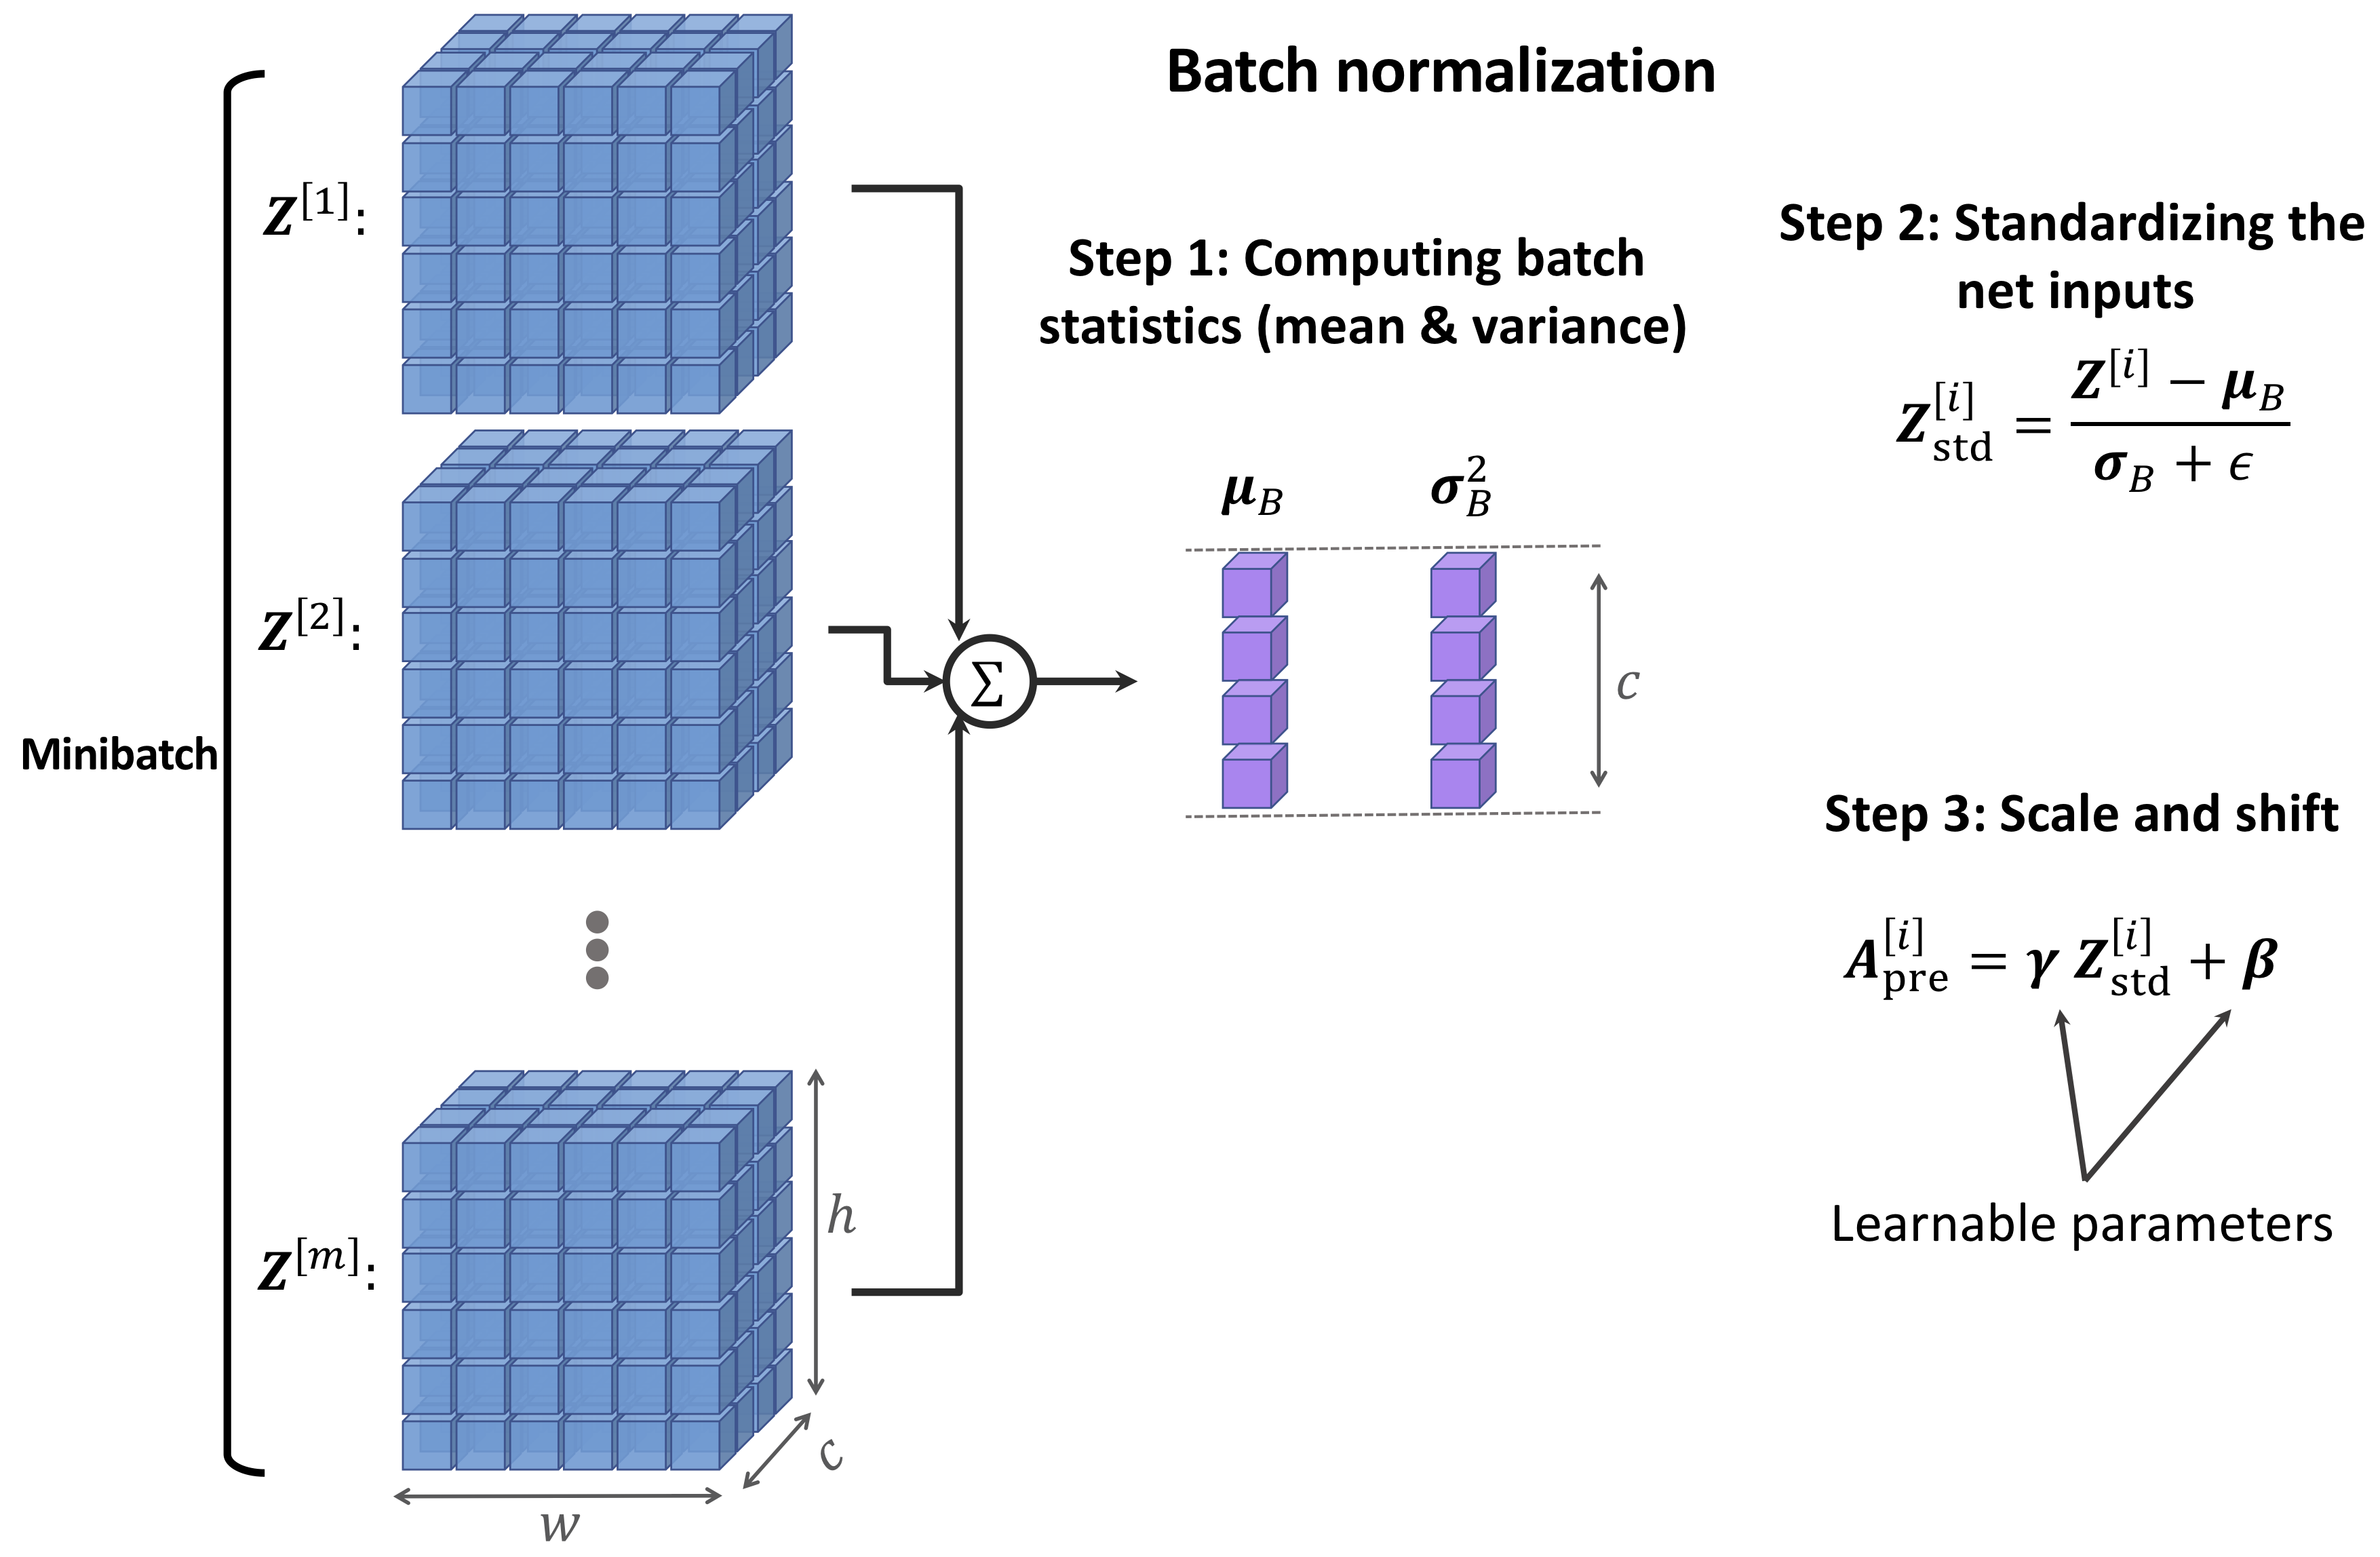

## 생성자와 판별자 구현
### 생성자
1. 벡터 z(크기:20)를 입력으로 받아 완전 연결 층을 적용해 크기를 6272로 늘림
2. 랭크 3 텐서(크기:7x7x128)로 변환
3. 전치 합성곱 몇 개를 거치면서 특성 맵을 공간 방향 차원이 28x28 될 때까지 업샘플링 
* 채널 개수가 절반으로 감소
* 마지막 전치 합성곱은 흑백 이미지 생성을 위해 하나의 출력 필터만 사용
* 배치 정규화와 LeakyReLU 활성화 함수 
* 마지막 전치 합성곱은 배치 정규화 없이 tanh 활성화 함수

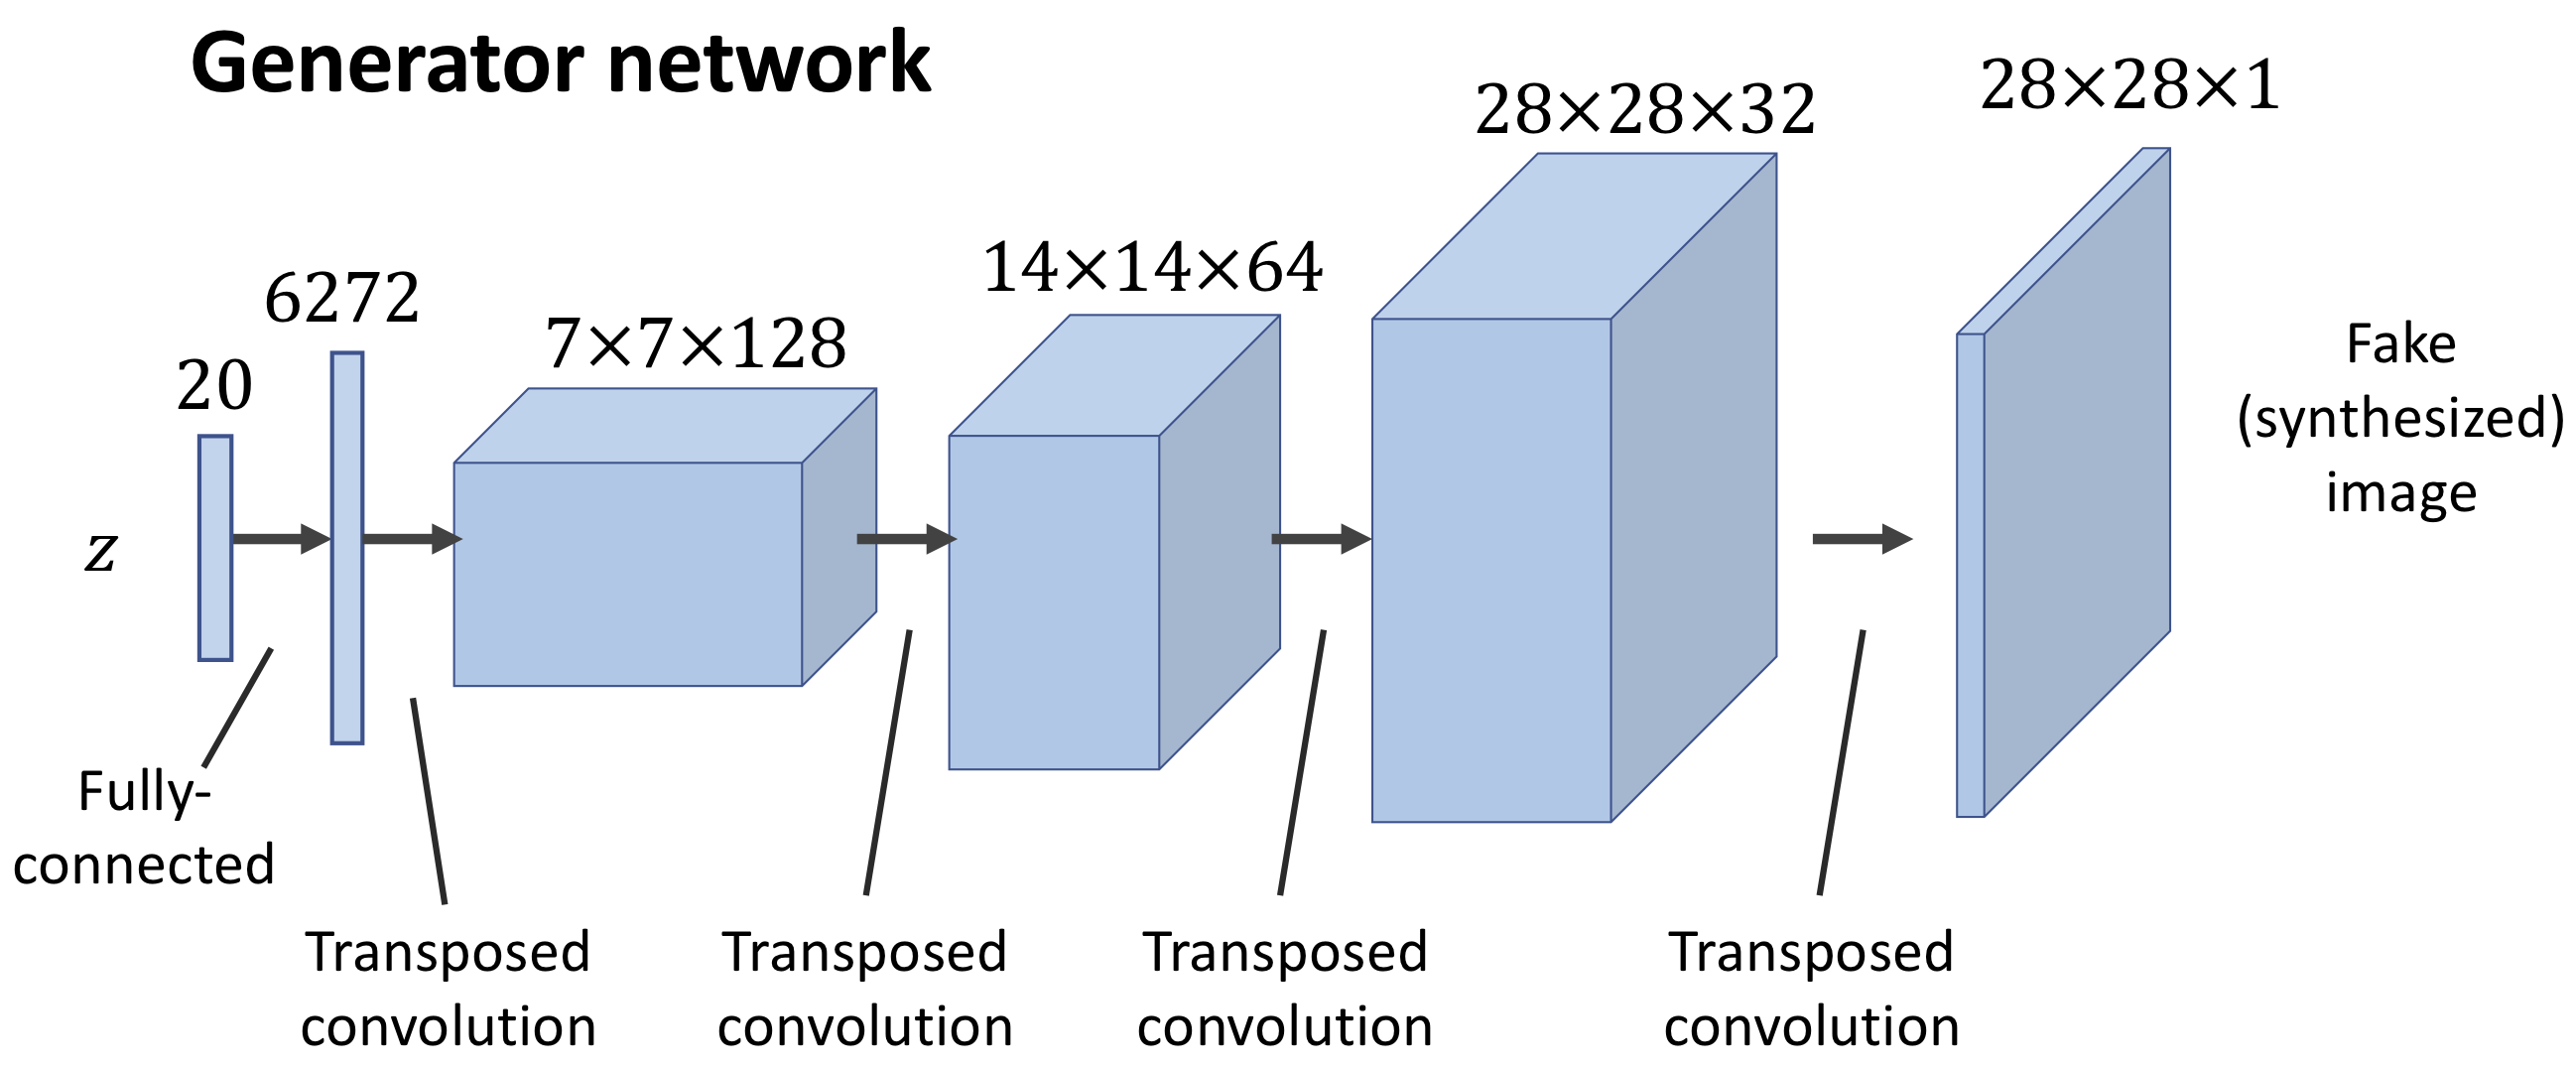

### 판별자
* 이미지(크기:28x28x1)를 입력으로 받아 4개의 합성곱 층을 통과
1.  첫번째 합성곱 층은 공간 차원을 4배로 줄이고, 특성 맵의 차원 개수를 늘림
2.  각 합성곱 층 다음에 배치 정규화, LeakyReLU 활성화 함수, 드롭아웃 rate=0.3
3.  마지막 합성곱은 7x7 크기의 커널 사용, 하나의 필터를 사용해 출력 차원을 1x1x1로 줄임
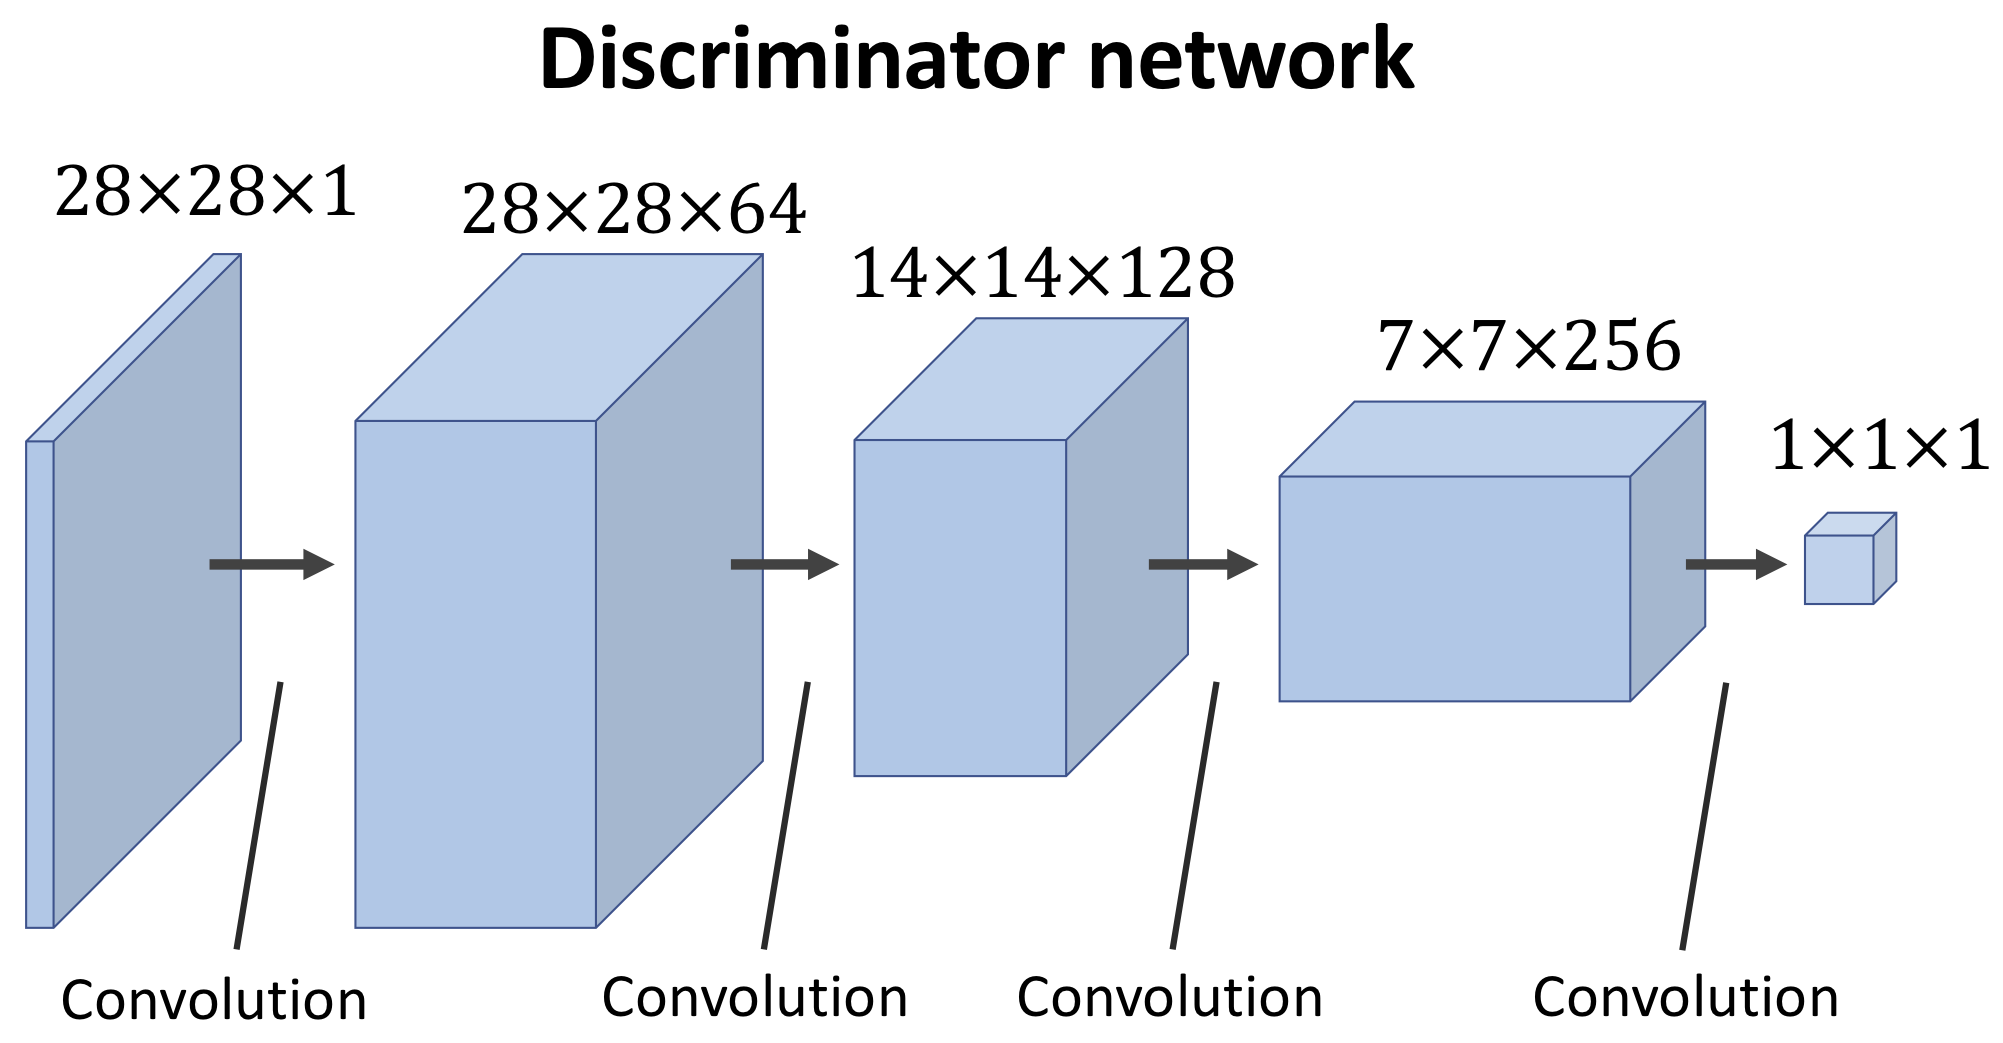

In [4]:
import tensorflow as tf


print(tf.__version__)

print("GPU 여부:", len(tf.config.list_physical_devices('GPU')) > 0)

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'CPU:0'
    
print(device_name)

2.9.2
GPU 여부: True
/device:GPU:0


In [5]:
def make_dcgan_generator(
        z_size=20, 
        output_size=(28, 28, 1),
        n_filters=128, 
        n_blocks=2):
    size_factor = 2**n_blocks
    hidden_size = (
        output_size[0]//size_factor, 
        output_size[1]//size_factor
    )
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        
        tf.keras.layers.Dense(
            units=n_filters*np.prod(hidden_size), 
            use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
            (hidden_size[0], hidden_size[1], n_filters)),
    
        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(5, 5), strides=(1, 1),
            padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
        
    nf = n_filters
    for i in range(n_blocks):
        nf = nf // 2
        model.add(
            tf.keras.layers.Conv2DTranspose(
                filters=nf, kernel_size=(5, 5), strides=(2, 2),
                padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
                
    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters=output_size[2], kernel_size=(5, 5), 
            strides=(1, 1), padding='same', use_bias=False, 
            activation='tanh'))
        
    return model

def make_dcgan_discriminator(
        input_size=(28, 28, 1),
        n_filters=64, 
        n_blocks=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(
            filters=n_filters, kernel_size=5, 
            strides=(1, 1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    
    nf = n_filters
    for i in range(n_blocks):
        nf = nf*2
        model.add(
            tf.keras.layers.Conv2D(
                filters=nf, kernel_size=(5, 5), 
                strides=(2, 2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))
        
    model.add(tf.keras.layers.Conv2D(
            filters=1, kernel_size=(7, 7), padding='valid'))
    
    model.add(tf.keras.layers.Reshape((1,)))
    
    return model

In [6]:
gen_model = make_dcgan_generator()
gen_model.summary()

disc_model = make_dcgan_discriminator()
disc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              125440    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        409600    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

## 두 분포 사이의 거리 측정
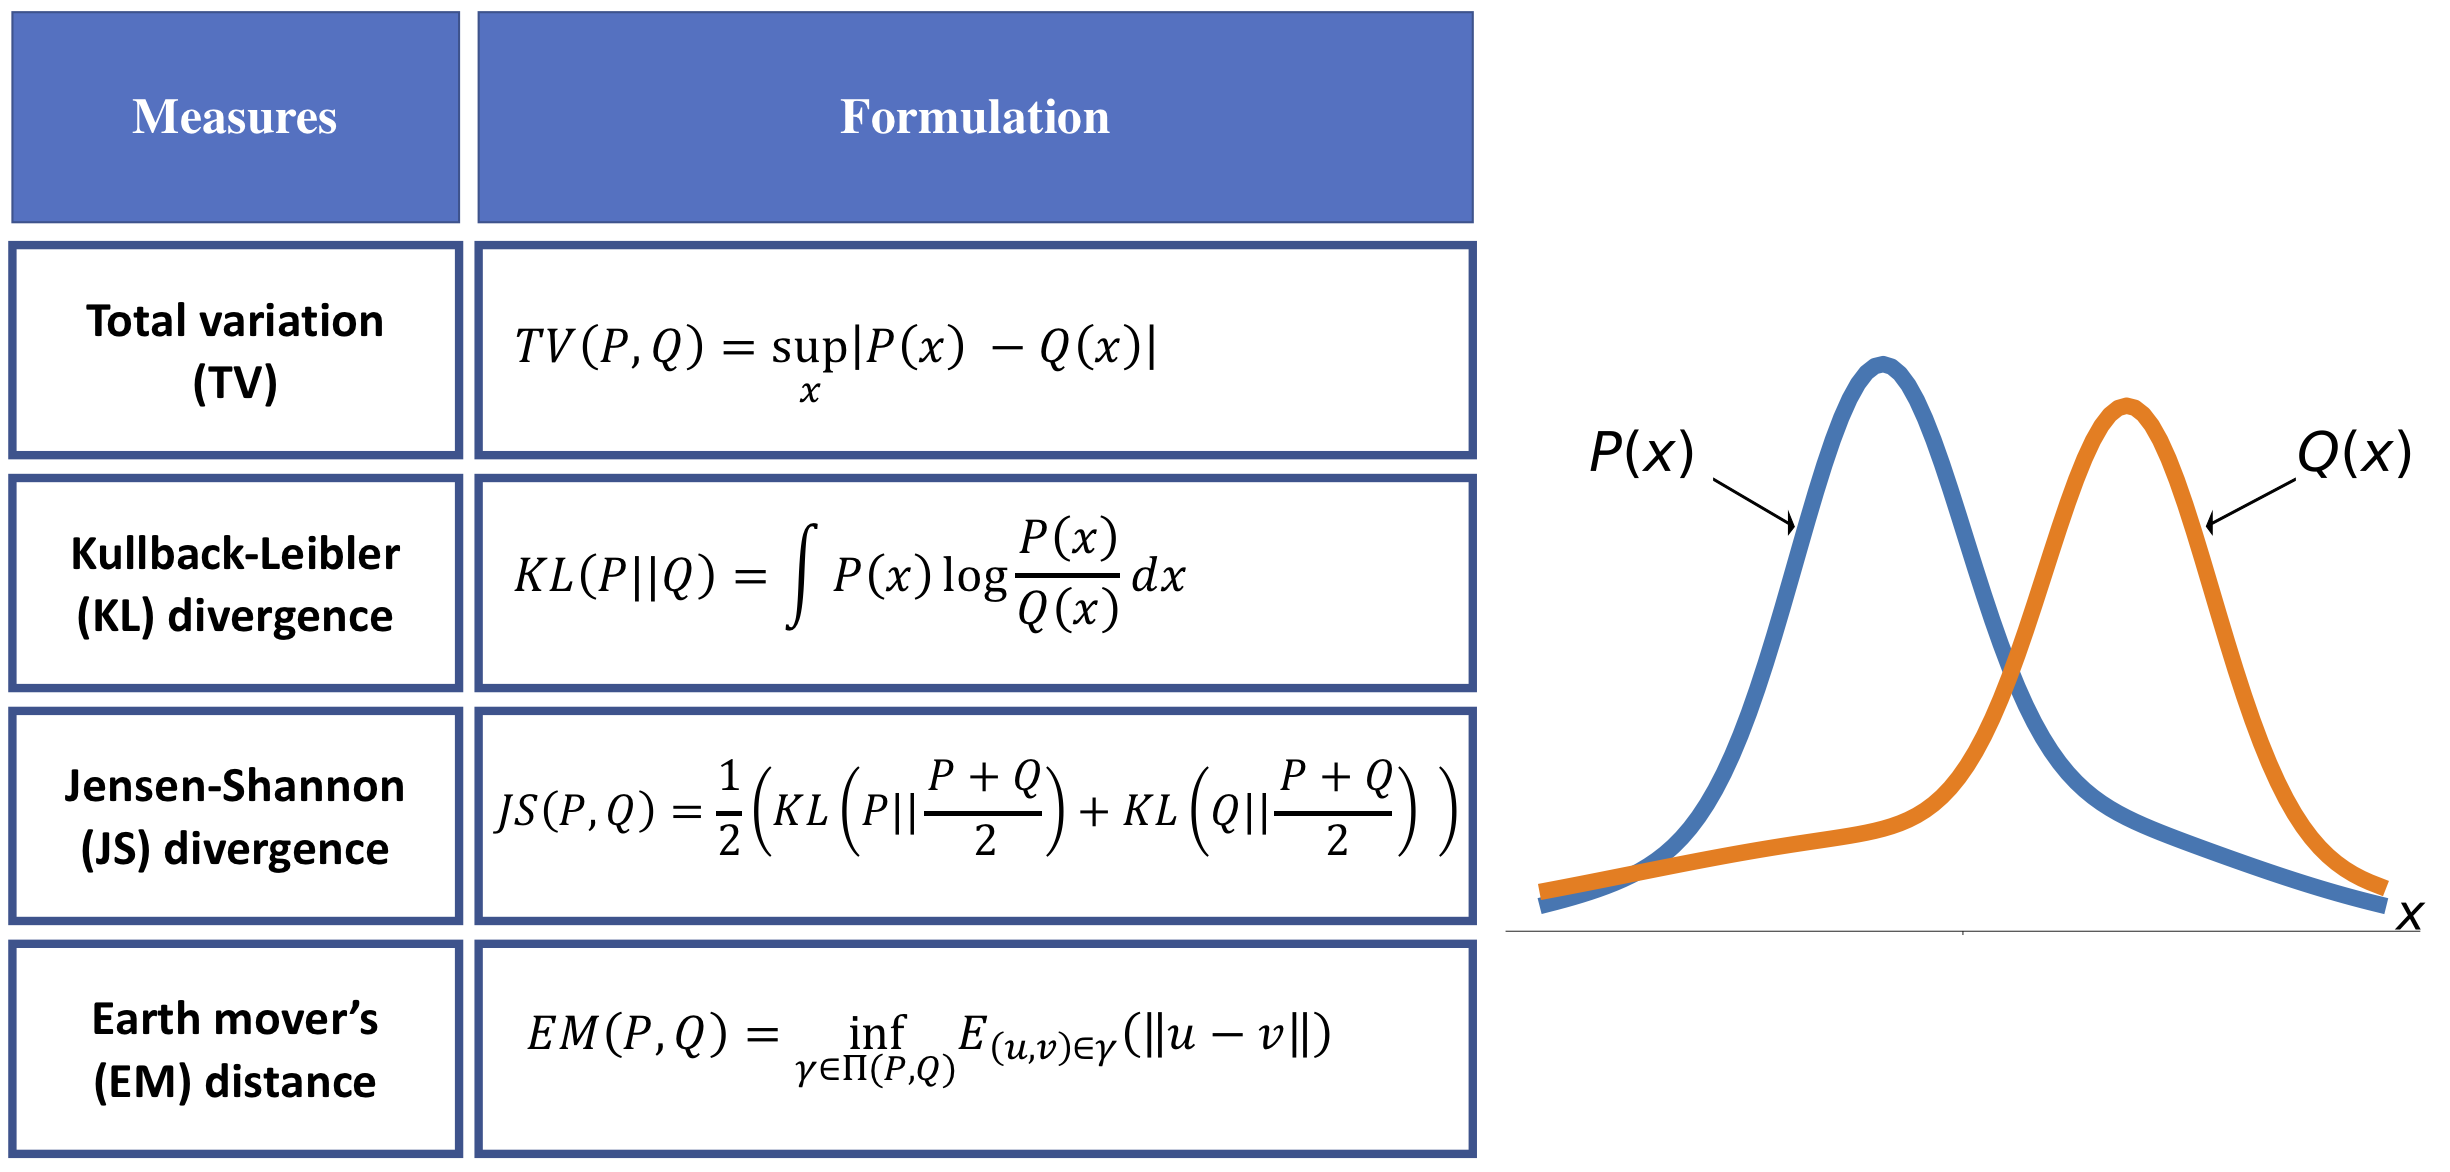

* 이산 분포 거리 측정
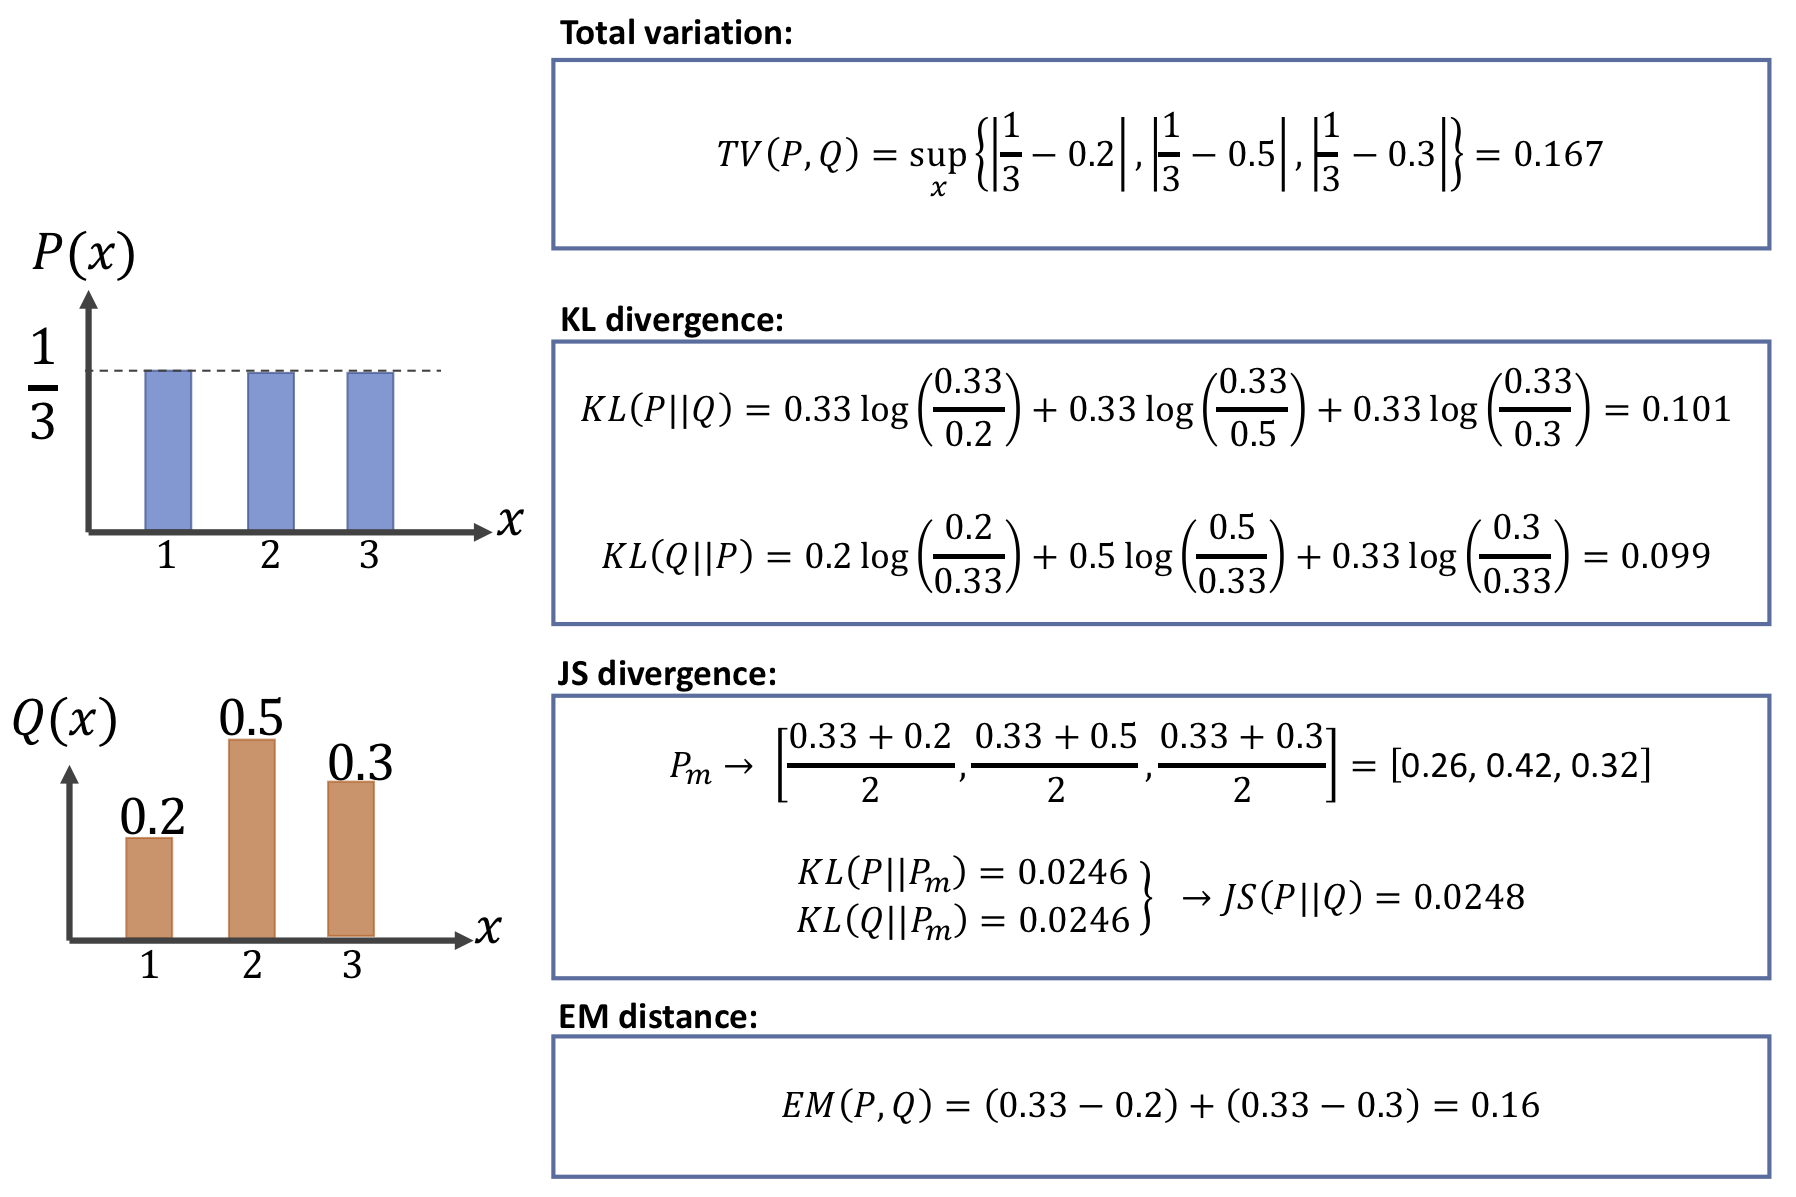

## GAN에 EM거리 사용 
* 진짜와 가짜 샘플 분포 사이의 거리 측정
* 훈련 성능 높임

### **WGAN** : 판별자를 비평자로 바꿔 확률 점수 대신 스칼라 점수를 반환
비평자 : 진짜 이미지 샘플의 배치와 합성 샘플 배치에 대한 출력 반환
-> $D(x), D(G(z))$
* 판별자 손질의 진짜 샘플에 대한 항 : $L^D_{real} = -\frac{1}{N} \sum_i D(\mathbf x_i)$
* 판별자 손실의 가짜 샘플에 대한 항 : $L^D_{fake} = \frac{1}{N} \sum_i D((G(\mathbf z_i)))$
* 생성자 손실 : $L^G = -\frac{1}{N} \sum_i D((G(\mathbf z_i)))$

## 그레이디언트 패널티
**WGAN-GP 과정**
1. 한 배치에서 진짜, 가짜 샘플 쌍 $(x^i, \tilde x^i)$에 대해 균등 분포에서 랜덤함 수 $\alpha^i$를 샘플링
2. 진짜, 가짜 샘플 사이를 $ \breve {x}^i = \alpha x^i + (1-\alpha) \tilde x^i$와 같이 보간 -> 보간된 샘플의 배치 생성
3. 보간된 전체 샘플에 대해 판별자 출력 $ D(\breve {x}^i)$ 계산
4. 각 보간된 샘플에 대해 비평자 출력의 그레이디언트 $ \triangledown_{\breve x^i} D(\breve {x}^i) $ 계산
5. $ L^D_{gp} = \frac{1}{N} (||\triangledown_{\breve x^i} D( \breve {x}^i )||_2 - 1)^2$와 같이 GP 계산

**판별자 총 손실**  
$ L^D_{total} = L^D_{real} + L^D_{fake} + λ^D_{gp}$

## WGAN-GP로 DCGAN 모델 훈련

In [7]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [8]:
num_epochs = 100
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0

tf.random.set_seed(1)
np.random.seed(1)

## 데이터셋 준비
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## 모델 생성
with tf.device(device_name):
    gen_model = make_dcgan_generator()
    gen_model.build(input_shape=(None, z_size))
    gen_model.summary()

    disc_model = make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))
    disc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              125440    
                                                                 
 batch_normalization_7 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 7, 7, 128)        409600    
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 7, 7, 128)       

In [1]:
import time


## 옵티마이저:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()

for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            ## 생성자 손실을 계산합니다:
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            ## 판별자 손실을 계산합니다:
            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake

            ## 그래디언트 페널티:
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = (
                    alpha*input_real + (1-alpha)*g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))
        
            d_loss = d_loss + lambda_gp*grad_penalty
        
        ## 최적화: 그래디언트를 계산하고 적용합니다
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
                    
    all_losses.append(epoch_losses)
    
    print('에포크 {:-3d} | 시간 {:.2f} min | 평균 손실 >>'
          ' 생성자/판별자 {:6.2f}/{:6.2f} [판별자-진짜: {:6.2f} 판별자-가짜: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(np.mean(all_losses[-1], axis=0)))
    )
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy()
    )

NameError: ignored

In [ ]:
import itertools


fig = plt.figure(figsize=(8, 6))

## 손실 그래프
ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()